In [1]:
import sys
sys.path.insert(0, "/home/gstupp/projects/metaproteomics")

In [2]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
from glob import glob
import numpy as np
from itertools import chain
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [3]:
from metaproteomics.file_processing.blazmass_tools import dta_select_parser, build_pep_quant_dict
from metaproteomics.goatools import obo_parser
goa = obo_parser.GODag()

load obo file /home/gstupp/projects/metaproteomics/metaproteomics/goatools/go-basic.obo
48437 nodes imported


In [4]:
files = glob("data/*/*/*.txt")

In [5]:
files

['data/PA/Triflic/PA triflic 4.txt',
 'data/PA/Triflic/PA triflic 3.txt',
 'data/PA/Triflic/PA triflic 5.txt',
 'data/PA/Sonic/PA sonic 1.txt',
 'data/PA/Sonic/PA sonic 3.txt',
 'data/PA/Sonic/PA sonic 4.txt',
 'data/Jurkat/Triflic/Jurkat triflic 1.txt',
 'data/Jurkat/Triflic/Jurkat triflic test.txt',
 'data/Jurkat/Triflic/Jurkat triflic 2.txt',
 'data/Jurkat/Sonic/Jurkat sonic 7.txt',
 'data/Jurkat/Sonic/Jurkat sonic 1.txt',
 'data/Jurkat/Sonic/Jurkat sonic 8.txt',
 'data/BS/Triflic/BS triflic 3.txt',
 'data/BS/Triflic/BS triflic 1.txt',
 'data/BS/Triflic/BS triflic 2.txt',
 'data/BS/Sonic/BS sonic 3.txt',
 'data/BS/Sonic/BS sonic 4.txt',
 'data/BS/Sonic/BS sonic 2.txt']

In [72]:
df = pd.read_csv("annotations.mapped.gaf", sep="\t", comment="!", header=None)
df = df.rename(columns={1:"id", 4:"go_id", 8:'aspect'})
#df = df.query("go_id != 'GO:0005575'")  # remove 'cellular component'
df.head(2)

,0,id,2,3,go_id,5,6,7,aspect,9,10,11,12,13,14,15,16
0,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0071944,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN
1,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0016020,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN


In [7]:
# sanity check, show all annotations
print(', '.join({goa[x].name: x for x in set(df['go_id'])}))

organelle, cytoplasm, cell periphery, cell, cellular_component, membrane


In [8]:
gb = df.groupby("id").agg({'go_id': lambda x: ','.join(x)})
annots = {k:v.split(",") for k,v in dict(zip(gb.index,gb.go_id)).items()}

In [9]:
len(annots)

23385

In [10]:
def get_proteins(loci):
    loci = [x for x in loci['loci'] if "|" in x['description']]
    for locus in loci:
        locus['uniprot'] = locus['description'].split("|")[1]
    return loci
locus = next(dta_select_parser(files[9], return_reverse=False))
get_proteins(locus)

[{'Descriptive Name': 'Tubulin alpha-1A chain (Fragment) OS=Homo sapiens GN=TUBA1A PE=4 SV=1 ',
  'EMPAI': 5.4268775,
  'Length': 26,
  'Locus': 0,
  'MolWt': 2704,
  'NSAF': 0.0028739145,
  'Sequence Count': 4,
  'Sequence Coverage': 0.8079999999999999,
  'Spectrum Count': 11,
  'Validation Status': 'U',
  'description': 'tr|F8VXZ7|F8VXZ7_HUMAN',
  'pI': 4.9,
  'reverse': False,
  'uniprot': 'F8VXZ7'}]

In [1]:
def get_go_count(file):
    """
    If a locus has multiple proteins, the go annotations for each protein are used and the spectral count assigned
    is divided by the number of proteins in the locus.
    If a protein has multiple go terms, the spectral count for that protein is divided by the number of GO terms
    """
    descr = dict()
    d = defaultdict(int)
    for locus in dta_select_parser(file, return_reverse=False):
        proteins = get_proteins(locus)
        for p in proteins:
            this_go = annots.get(p['uniprot'], [])
            descr[p['uniprot']] = {'go': ";".join(this_go), 'q': locus['quantification'], 
                          'go_name': ";".join([goa[x].name for x in this_go]), 
                          'name': p['Descriptive Name']}
            for go in this_go:
                c = (locus['quantification']/len(proteins))/len(this_go)
                d[go]+=c
            if not this_go:
                d['unknown']+=locus['quantification']/len(proteins)
            if "GO:0043226" in this_go:
                print(str(c) + "|" + p['Descriptive Name'])
    d = dict(d)
    return d, descr

#d,p = get_go_count(files[12])

In [12]:
def get_membrane_count(d):
    # cell periphery and membrane == membrane
    membrane = {'GO:0071944', 'GO:0016020'}
    membrane_count = sum(count for go,count in d.items() if go in membrane)
    not_membrane_count = sum(count for go,count in d.items() if go not in membrane and go!="unknown")
    return membrane_count, not_membrane_count

In [21]:
counts = dict()
all_counts = dict()
for file in tqdm(files):
    d,p = get_go_count(file)
    all_counts[file] = {goa[k].name if k!="unknown" else "unknown":v for k,v in d.items()}
    membrane_count, not_membrane_count = get_membrane_count(d)
    counts[file] = (membrane_count, not_membrane_count, np.log(membrane_count/not_membrane_count))
    pd.DataFrame(p).T.to_csv(file + "_go_counts.csv")

100%|██████████| 18/18 [00:03<00:00,  5.24it/s]


In [22]:
df_out = pd.DataFrame({'files': list(counts.keys()),
 'membrane': [x[0] for x in counts.values()],
 'non-membrane': [x[1] for x in counts.values()],
 'ratio': [x[2] for x in counts.values()],
 'method': ["sonic" if "sonic" in file else "tri" for file in counts],
 'cell': [file.split("/")[1] for file in counts]})
df_out = df_out.sort_values(["cell", "method"])
df_out

,cell,files,membrane,method,non-membrane,ratio
1,BS,data/BS/Sonic/BS sonic 2.txt,2147.900502,sonic,15042.099498,-1.946362
11,BS,data/BS/Sonic/BS sonic 4.txt,1938.027914,sonic,13957.972086,-1.974380
16,BS,data/BS/Sonic/BS sonic 3.txt,1810.113983,sonic,13497.886017,-2.009143
4,BS,data/BS/Triflic/BS triflic 3.txt,2918.966170,tri,24296.033830,-2.119084
6,BS,data/BS/Triflic/BS triflic 2.txt,2440.764763,tri,20389.235237,-2.122696
7,BS,data/BS/Triflic/BS triflic 1.txt,1582.936852,tri,11859.063148,-2.013811
0,Jurkat,data/Jurkat/Sonic/Jurkat sonic 8.txt,2297.343065,sonic,19091.923058,-2.117512
14,Jurkat,data/Jurkat/Sonic/Jurkat sonic 7.txt,3182.184302,sonic,20449.608374,-1.860396
15,Jurkat,data/Jurkat/Sonic/Jurkat sonic 1.txt,2609.509022,sonic,17737.063597,-1.916494
5,Jurkat,data/Jurkat/Triflic/Jurkat triflic 1.txt,494.086119,tri,4267.349490,-2.156038


In [23]:
df_out.to_csv("df_out.csv")

In [24]:
%matplotlib inline

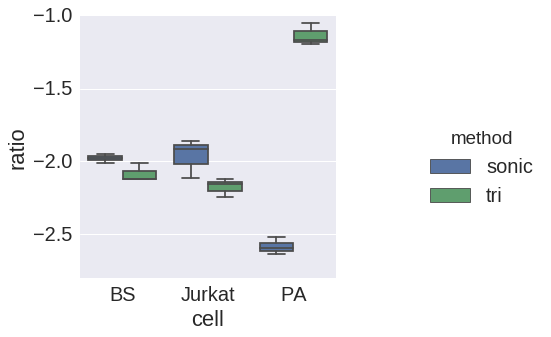

In [25]:
import seaborn as sns
sns.set(font_scale=2)
g = sns.factorplot(x="cell", y="ratio", hue="method", data=df_out, kind="box")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

In [69]:
all_counts = pd.DataFrame(all_counts)
all_counts.head()

,cell,cell periphery,cellular_component,cytoplasm,membrane,organelle,unknown
BS sonic 2,3055.747550,739.478580,648.521284,10917.373629,1408.421923,420.457035,9499.0
BS sonic 3,3265.455680,620.313592,524.639472,9333.060148,1189.800391,374.730717,8636.0
BS sonic 4,2740.860409,655.989832,676.496631,10179.250982,1282.038081,361.364064,9077.0
BS triflic 1,1839.329765,593.586050,391.679482,9014.220291,989.350802,613.833611,6424.0
BS triflic 2,3136.300555,880.134676,704.882295,15838.645543,1560.630087,709.406843,8810.0


In [68]:
all_counts = all_counts.T
all_counts.index = all_counts.index.map(lambda x:x.split("/")[-1].split(".")[0])
all_counts.to_csv("all_counts.csv")
all_counts

,cell,cell periphery,cellular_component,cytoplasm,membrane,organelle,unknown
BS sonic 2,3055.747550,739.478580,648.521284,10917.373629,1408.421923,420.457035,9499.000000
BS sonic 3,3265.455680,620.313592,524.639472,9333.060148,1189.800391,374.730717,8636.000000
BS sonic 4,2740.860409,655.989832,676.496631,10179.250982,1282.038081,361.364064,9077.000000
BS triflic 1,1839.329765,593.586050,391.679482,9014.220291,989.350802,613.833611,6424.000000
BS triflic 2,3136.300555,880.134676,704.882295,15838.645543,1560.630087,709.406843,8810.000000
BS triflic 3,4036.621942,1119.679751,847.638994,18211.113955,1799.286419,1200.658938,10981.000000
Jurkat sonic 1,4774.609898,1024.083085,1066.811191,5028.782847,1585.425937,6866.859661,18792.427381
Jurkat sonic 7,4159.516938,1290.705648,2888.496939,6437.163632,1891.478654,6964.430865,19077.207323
Jurkat sonic 8,5257.433035,903.538090,1276.906876,4838.873687,1393.804975,7718.709460,17101.733877
Jurkat triflic 1,1156.251284,186.885675,192.472227,1301.916983,307.200444,1616.708996,3935.564391


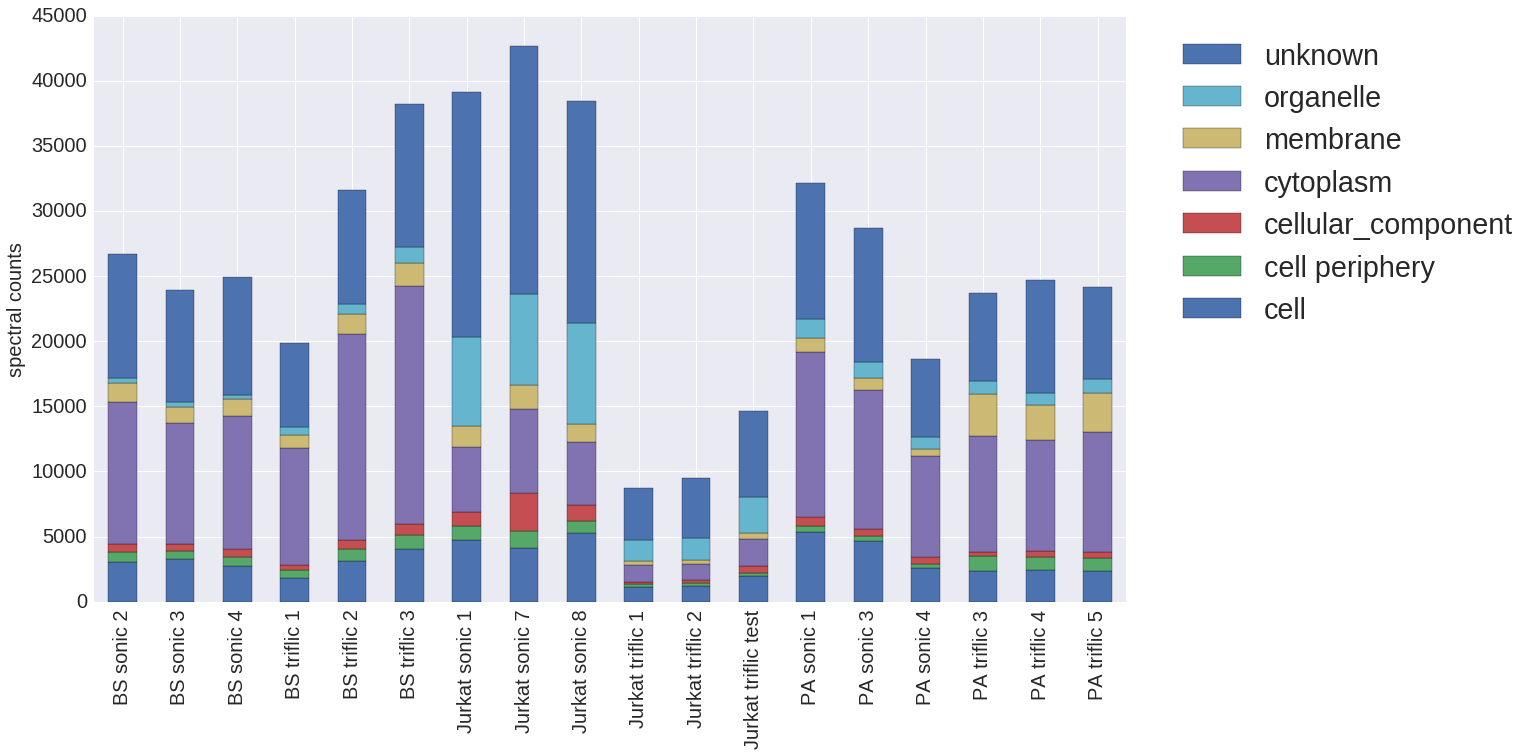

In [70]:
ax = all_counts.plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

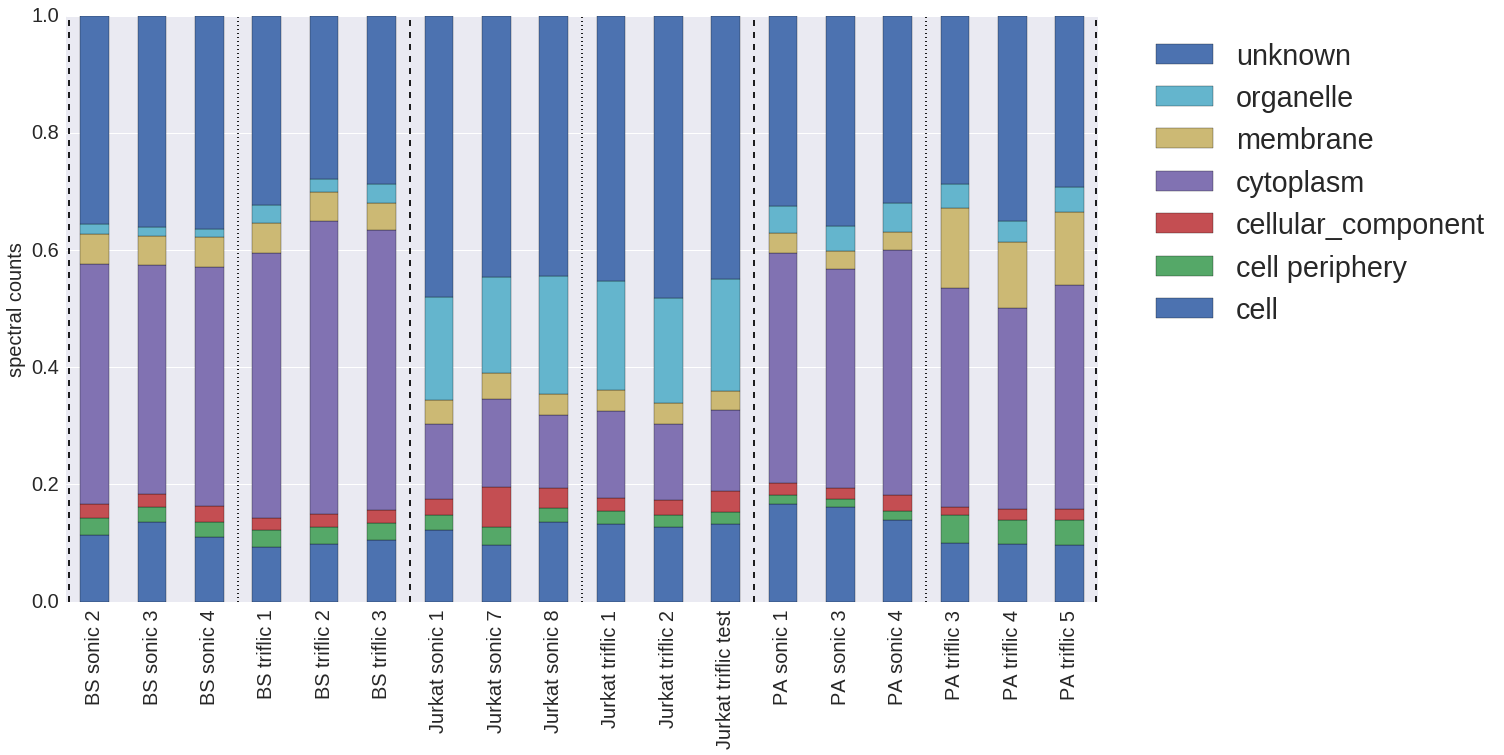

In [64]:
ax = all_counts.div(all_counts.sum(1), axis=0).plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
ax.set_ylim(0,1)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.axvline(x=-0.45, linestyle='--', color='k')
ax.axvline(x=5.5, linestyle='--', color='k')
ax.axvline(x=11.5, linestyle='--', color='k')
ax.axvline(x=17.45, linestyle='--', color='k')
ax.axvline(x=2.5, linestyle=':', color='k')
ax.axvline(x=8.5, linestyle=':', color='k')
ax.axvline(x=14.5, linestyle=':', color='k')

In [32]:
df = all_counts.T
gs = ["BS sonic", "BS triflic", "Jurkat sonic", "Jurkat triflic", "PA sonic", "PA triflic"]
for g in gs:
    df[g] = df[df.columns[df.columns.str.contains(g)]].sum(1)
df = df[gs]
df3 = df.T

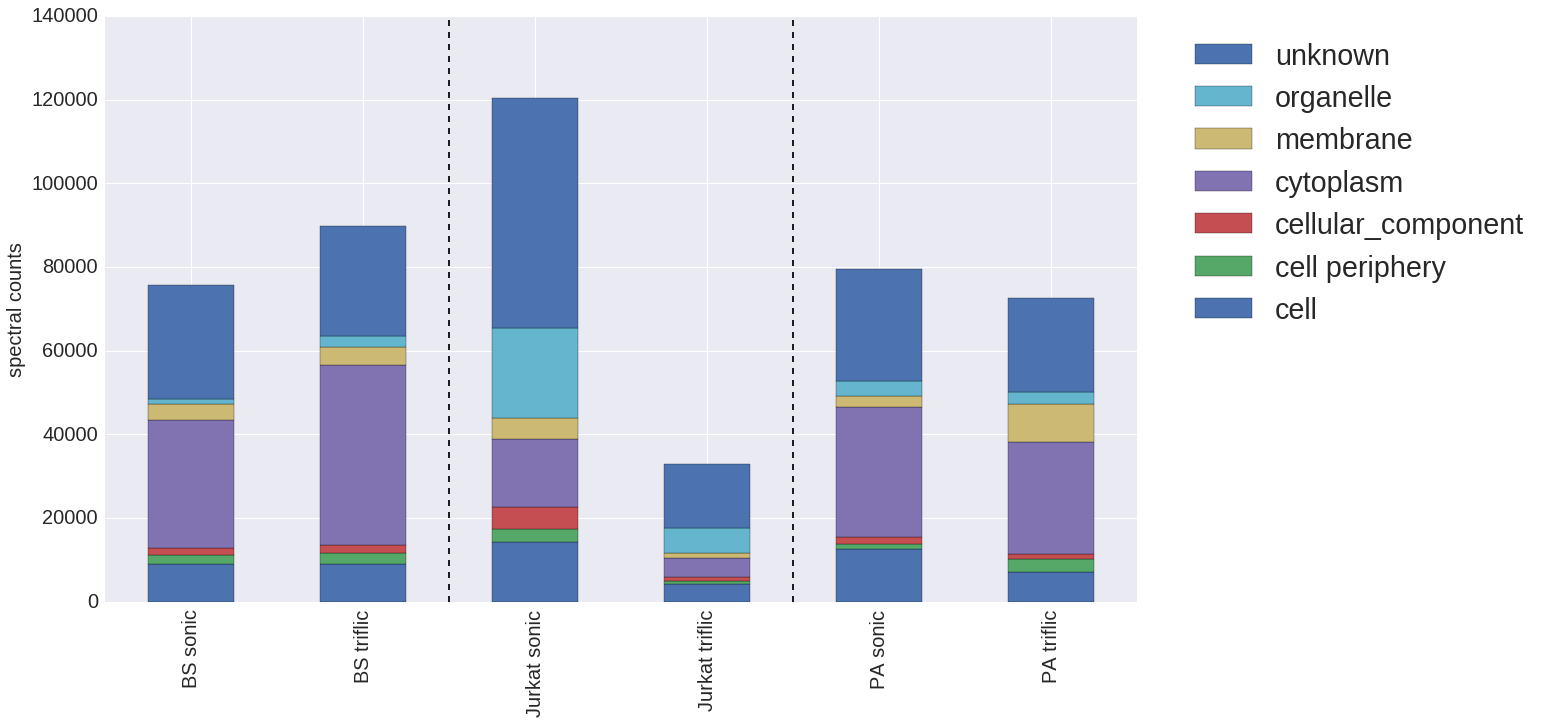

In [48]:
ax = df3.plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.axvline(x=1.5, linestyle='--', color='k')
ax.axvline(x=3.5, linestyle='--', color='k')

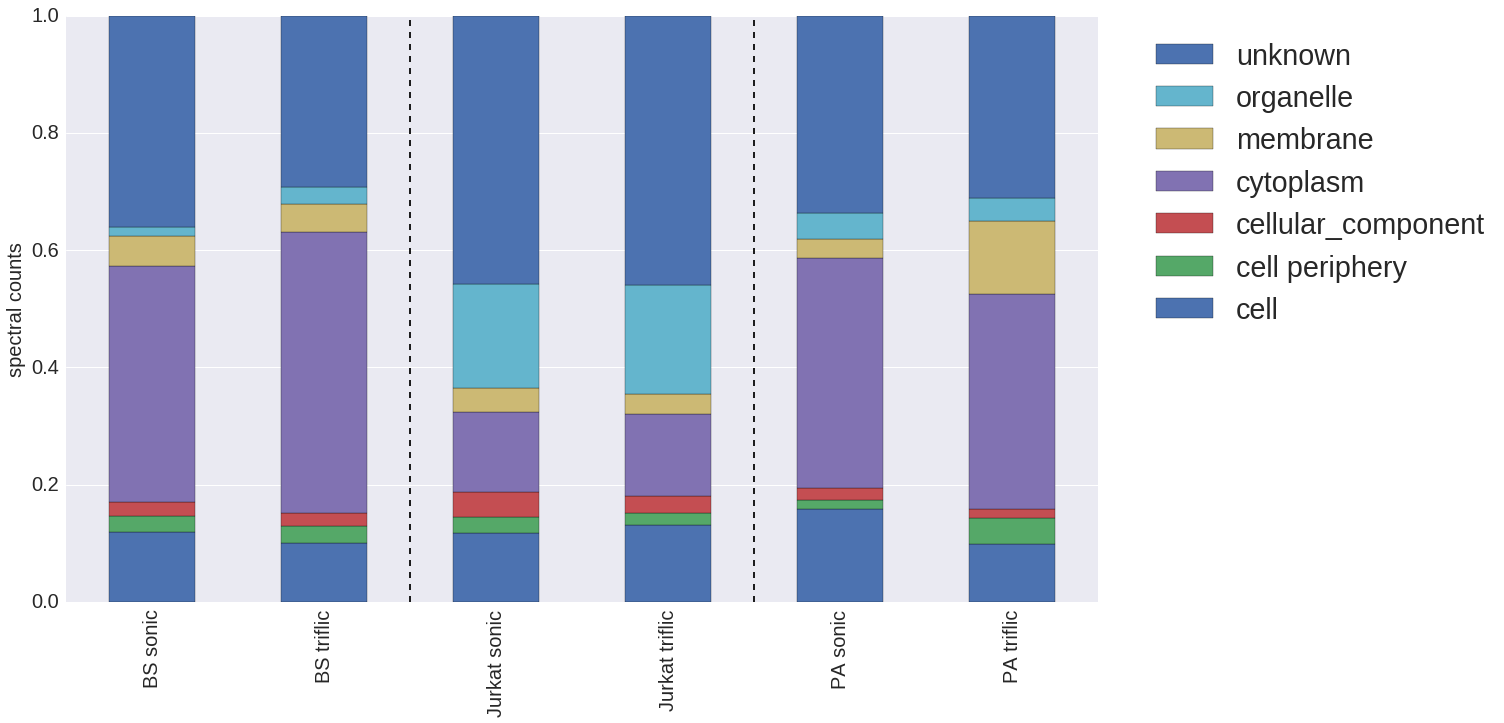

In [47]:
ax = df3.div(df3.sum(1), axis=0).plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
ax.set_ylim(0,1)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.axvline(x=1.5, linestyle='--', color='k')
ax.axvline(x=3.5, linestyle='--', color='k')